In [3]:
!pip3 install --upgrade --user pip lightgbm

Requirement already up-to-date: pip in /home/ec2-user/.local/lib/python3.6/site-packages (19.3.1)
     |████████████████████████████████| 1.2MB 32.6MB/s eta 0:00:01


In [ ]:
# !pip install pystan==2.14
# !pip install fbprophet
# or below is better
!conda install -c plotly plotly==3.10.0 --yes
!conda install -c conda-forge fbprophet --yes

In [ ]:
#!pip install pandas==0.22  # Notice: newest pandas may have bug

In [58]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')

import json

import lightgbm as lgb

from lightgbm import plot_importance, plot_tree

try:
    # To enable interactive mode you should install ipywidgets
    # https://github.com/jupyter-widgets/ipywidgets
    from ipywidgets import interact, SelectMultiple
    INTERACTIVE = True
except ImportError:
    INTERACTIVE = False

## Data Prepare

In [2]:
df = pd.read_csv('timeseries_raw.csv', header=None, sep=',', index_col=[0], parse_dates=[0])
df = df[~df.index.isnull()]

df

,1,2,3,4,5,6,7,8,9,10,...,1595,1596,1597,1598,1599,1600,1601,1602,1603,1604
0,,,,,,,,,,,,,,,,,,,,,
2019-07-10,14.0,630.7,2074.9,1305.5,3629.0,993.5,1119.5,915.1,1118.0,3123.7,...,1575.6,561.1,1024.2,1156.1,907.8,604.6,1793.7,3159.7,1972.5,617.5
2019-07-11,18.0,764.3,1057.9,596.8,1368.8,816.2,1303.8,642.2,1004.6,2832.2,...,1482.1,573.5,1446.8,1564.6,925.8,774.0,1553.0,2983.9,1337.3,490.5
2019-07-12,22.4,673.7,1278.2,1055.9,1436.6,1186.3,2160.9,936.2,735.9,3013.7,...,1290.2,625.8,1187.5,1417.7,1048.2,756.3,2257.3,3241.3,2014.8,743.0
2019-07-13,28.5,701.3,1975.9,905.2,1222.7,501.7,1363.5,1476.7,1173.3,1868.3,...,385.1,533.9,1104.4,1170.9,635.1,1159.0,2245.7,1940.7,2256.5,497.5
2019-07-14,25.0,737.5,1641.7,1122.0,1139.1,81.3,1159.0,832.7,1104.4,1356.0,...,309.0,601.7,1287.2,735.2,645.8,945.4,1457.2,1482.5,1930.7,816.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-26,154.4,1471.8,891.2,588.4,508.3,1474.3,833.4,752.4,570.8,3071.9,...,1081.3,668.2,1092.6,1036.4,628.2,708.8,788.7,2716.6,1222.5,812.5
2019-09-27,174.1,400.6,777.4,540.1,864.8,776.8,1129.4,724.7,1214.5,3041.6,...,1294.9,389.3,1398.4,1405.9,659.9,511.5,1481.6,4626.4,874.3,461.5
2019-09-28,27.0,556.3,1678.9,1299.8,789.8,208.8,1178.8,1527.9,1178.5,1651.3,...,423.2,704.3,1612.1,1541.3,296.3,1051.7,1426.5,1527.2,1755.5,925.5


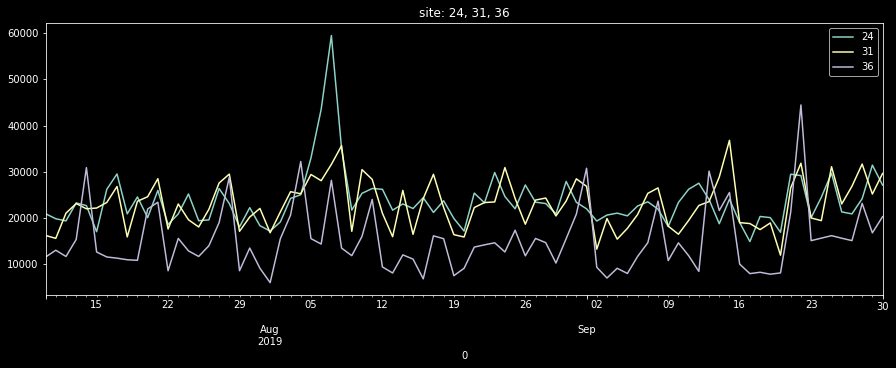

In [28]:
_ = df.loc[:,[24,31,36]].plot(style='-', figsize=(15,5), title='site: 24, 31, 36')

In [42]:
# 2019-07-10 00:00:00 to 2019-10-09 23:59:59

DATETIME_START_OF_TRAIN = "2019-07-10 00:00:00"
DATETIME_END_OF_TRAIN = "2019-09-17 00:00:00"
DATETIME_START_OF_TEST = DATETIME_END_OF_TRAIN
DATETIME_END_OF_TEST = "2019-09-24 00:00:00"
DATETIME_START_OF_PREDICT = DATETIME_END_OF_TEST
DATETIME_END_OF_PREDICT = "2019-10-01 00:00:00"

freq = '1D'
prediction_length = 7
context_length = 14

cols = [24, 31, 36]

In [53]:
df_train = df.loc[df.index <= DATETIME_START_OF_TEST, cols].copy()
df_test = df.loc[(df.index >= DATETIME_START_OF_TEST) & (df.index <= DATETIME_START_OF_PREDICT), cols].copy()

In [54]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    #df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

## Configuration dictionary

In [56]:
params = {
    'num_leaves': 5,
    'metric': ['l1', 'l2'],
    'verbose': -1
}

/home/ec2-user/.local/lib/python3.6/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [21]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[10]	training's l1: 3451.35	training's l2: 3.2627e+07	valid_1's l1: 4464.96	valid_1's l2: 2.51356e+07
[20]	training's l1: 3337.66	training's l2: 2.91973e+07	valid_1's l1: 4308.96	valid_1's l2: 2.47303e+07
[30]	training's l1: 3253.23	training's l2: 2.65744e+07	valid_1's l1: 4199.04	valid_1's l2: 2.49123e+07
[40]	training's l1: 3169.66	training's l2: 2.4676e+07	valid_1's l1: 4127.79	valid_1's l2: 2.48041e+07
[50]	training's l1: 3089.79	training's l2: 2.31128e+07	valid_1's l1: 4080.86	valid_1's l2: 2.47044e+07
[60]	training's l1: 3029.52	training's l2: 2.17436e+07	valid_1's l1: 4049.12	valid_1's l2: 2.42891e+07
[70]	training's l1: 2964.67	training's l2: 2.06297e+07	valid_1's l1: 4050.28	valid_1's l2: 2.42955e+07
[80]	training's l1: 2907	training's l2: 1.96795e+07	valid_1's l1: 4052.56	valid_1's l2: 2.42937e+07
[90]	training's l1: 2866.1	training's l2: 1.88474e+07	valid_1's l1: 4055.31	valid_1's l2: 2.43371e+07
[100]	training's l1: 2839.52	training's l2: 1.81117e+07	valid_1's l1: 4038.26	v

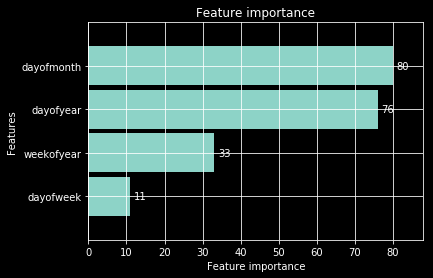

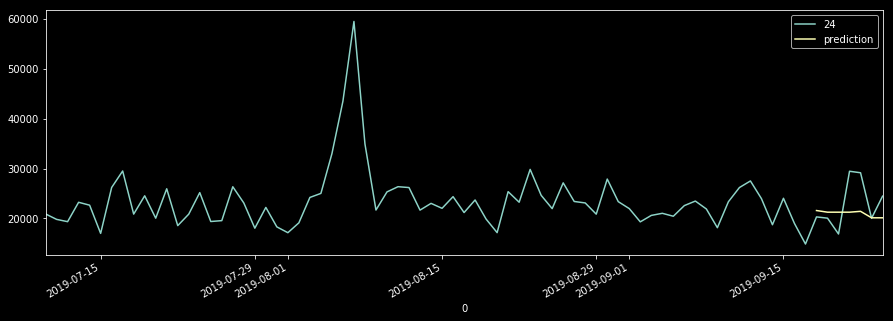

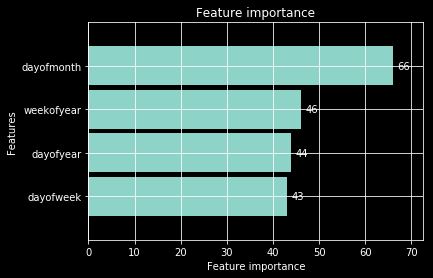

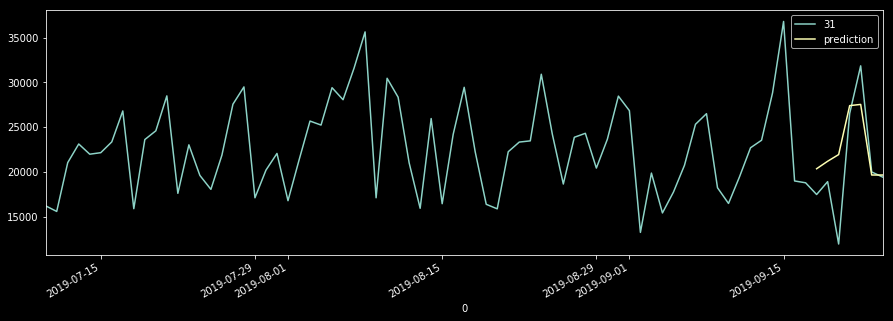

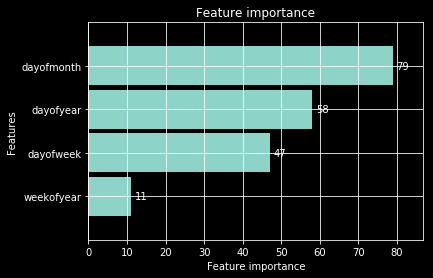

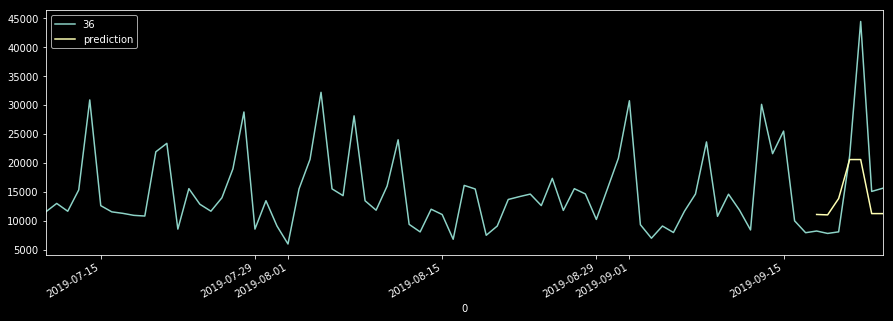

In [63]:
for col in cols:
#     _ = df_test.loc[:,[col]] \
#         .rename(columns={col: 'TEST SET'}) \
#         .join(df_train.loc[:,[col]].rename(columns={col: 'TRAINING SET'}), how='outer') \
#         .plot(figsize=(15,5), title=f"site: {col}", style='-')
    
    X_train, y_train = create_features(df_train, label=col)
    X_test, y_test = create_features(df_test, label=col)
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)
    
    evals_result = {}  # to record eval results for plotting
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=100,
                    valid_sets=[lgb_train, lgb_test],
                    #feature_name=['f' + str(i + 1) for i in range(X_train.shape[-1])],
                    categorical_feature=[21],
                    evals_result=evals_result,
                    verbose_eval=10)
    
    _ = plot_importance(gbm, height=0.9)
    
    df_test['prediction'] = gbm.predict(X_test)
    df_all = pd.concat([df_test, df_train], sort=False)
    _ = df_all[[col,'prediction']].plot(figsize=(15, 5))

## Estimator Model

## Predictor Model

## Select a predictor

## Evaluation

## Evaluate All Customer